<a id='Table of Contents'></a><h3>Table of Contents</h3>

- <a href='#introduction'>Introduction</a> 
- <a href='#imports'>Import and install required librairies</a>  
- <a href='#setting_fitting'>Setting of fitting</a>  
- <a href='#run_fit'>Running the fit</a>  
- <a href='#results'>Showing the results</a> 

(<a href='#Table of Contents'>Top</a>)<a id='introduction'></a><h2>Introduction</h2>

<div class="alert alert-block alert-info">
The objective of this notebook is to show how to use the **Brownian Translational diffusion** model to perform some 
fits using [bumps](https://github.com/bumps/bumps).
</div>

The **reference data** were generated data corresponding to a Brownian Translational diffusion model with self-diffusion coefficient = 0.145 AA$^2\times$meV.

The model was convoluted with a Gaussian resolution function 
of FWHM = 0.1 meV, centered randomly in the range \[-0.01, +0.01\] meV.

Finally the data are sampled randomly from a Poisson distribution.

The data do not have a background. 

(<a href='#Table of Contents'>Top</a>)<a id='imports'></a><h2> Import python modules for plotting, fitting... </h2>

In [1]:
# Imported required libraries
from __future__ import print_function
import sys
import os

import ipywidgets

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# install bumps (if not already installed)
!{sys.executable} -m pip install bumps

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


 (<a href='#Table of Contents'>Top</a>)<a id='setting_fitting'></a><h2>Setting of fitting </h2>
<h3> load data, prepare data, create fitting model and set initial guesses </h3>

These settings are saved in a Python script, which will be used by Bumps to run the fit.


In [3]:
# Name of Python script containing the model
model_file = "model_fit_BrownianTranslationalDiffusion.py"

In [4]:
%%writefile $model_file

# %%writefile model_fit_BrownianTranslationalDiffusion.py
import h5py
import QENSmodels
import numpy as np
from scipy.integrate import simps
from bumps.names import *

path_to_data = './data/'

# Read the sample
f = h5py.File(path_to_data + 'BrownianDiff_Sample.hdf', 'r')
hw = f['entry1']['data1']['X'][:]
q = f['entry1']['data1']['Y'][:]
sqw = np.transpose(f['entry1']['data1']['DATA'][:])
err = np.transpose(f['entry1']['data1']['errors'][:])
f.close()

# Read resolution
f = h5py.File(path_to_data + 'BrownianDiff_Resol.hdf', 'r')
res = np.transpose(f['entry1']['data1']['DATA'][:])
f.close()

# Force resolution function to have unit area
for i in range(len(q)):
    area = simps(res[:,i], hw)
    res[:,i] /= area   


# Fitting model 
def model_convol(x, q, scale=1, center=0, D=1, resolution=None):
    model = QENSmodels.sqwBrownianTranslationalDiffusion(x, q, scale, center, D)
    return np.convolve(model, resolution/resolution.sum(), mode='same')

# Fit
M = []

for i in range(len(q)):

    # Bumps fitting model
    Mq = Curve(model_convol, hw, sqw[:,i], err[:,i], q=q[i],          
               scale=1000, center=0.0, D=0.1, resolution=res[:, i])
    Mq.scale.range(0, 1e5)
    Mq.center.range(-0.1, 0.1)
    Mq.D.range(0,1)
    
    # Q-independent parameters
    if i == 0:
        QD = Mq.D  
    else:
        Mq.D = QD
    M.append(Mq)
        
problem = FitProblem(M)

Writing model_fit_BrownianTranslationalDiffusion.py


<h3> Choice of minimizer for bumps </h3>

In [5]:
w_choice_minimizer = ipywidgets.widgets.Dropdown(
    options={'Levenberg-Marquardt': "lm", 
             'Nelder-Mead Simplex': "amoeba", 
             'DREAM': "dream", 
             'Differential Evolution': "de", 
             'Quasi-Newton BFGS': "newton", 
             'Random Lines (experimental)': "rl", 
             'Particle Swarm (experimental)': "ps", 
             'Parallel Tempering (experimental)': "pt"},
    value="lm",
    description='Minimizer:',)

display(w_choice_minimizer)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


<h3> Setting for running bumps </h3>

In [6]:
# CHOICE OF MINIMIZER
minimiser = w_choice_minimizer.value

# NUMBER OF STEPS WHEN RUNNING THE FIT
steps = 100

# output folder to save thre results
output_folder = 'QENS'

(<a href='#Table of Contents'>Top</a>)<a id='running_fit'></a><h2>Running the fit</h2>

Run the fit using the *minimizer* defined above with a number of *steps* also specified above
The subfolder *output_folder* contains different results: plots and 
refined parameters

/Users/celinedurniak/anaconda/envs/icetenv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# /Users/celinedurniak/anaconda/envs/icetenv/lib/python3.6/site-packages/bumps/cli.py model_fit_BrownianTranslationalDiffusion.py --fit=lm --steps=100 --store=QENS
-- Model 0 
.D = 0.1 in [0,1]
.center = 0 in [-0.1,0.1]
.q = 0.2
.scale = 1000 in [0,100000]

[chisq=2409.7129(88), nllf=483147]
-- Model 1 
.D = 0.1 in [0,1]
.center = 0 in [-0.1,0.1]
.q = 0.4
.scale = 1000 in [0,100000]

[chisq=1169.3831(88), nllf=234461]
-- Model 2 
.D = 0.1 in [0,1]
.center = 0 in [-0.1,0.1]
.q = 0.6
.scale = 1000 in [0,100000]

[chisq=681.5860(88), nllf=136658]
-- Model 3 
.D = 0.1 in [0,1]
.center = 0 in [-0.1,0.1]
.q = 0.8
.scale = 1000 in [0,100000]

[chisq=364.0785(88), nllf=72997.7]
-- Model 4 
.D = 0.1 in [0,1]
.center = 0 in [-0.1,0.1]
.q = 1
.scale = 1000 in [0,100000]

[chisq=166.2761(88), nllf=33338.4]
-- Model 5 
.D = 0.1 in [0,1]
.center = 0 in [-0.1,0.1]
.q = 1.2
.scale = 1000 in [0,100000]

[chisq=61.9759(88), nllf=12426.2]
-- Model 6 
.D = 0.1 in [0,1]
.center = 0 in [-0.1,0.1]
.q = 1.4
.

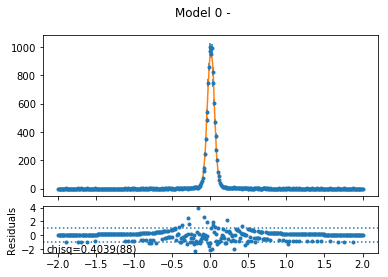

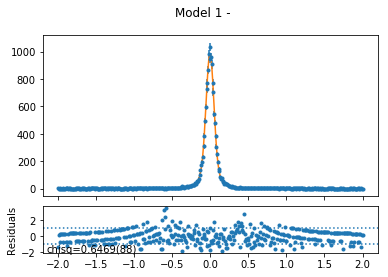

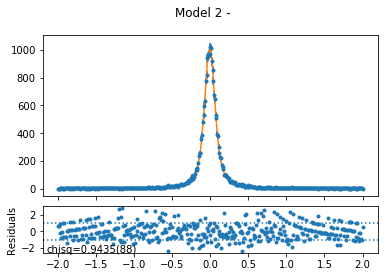

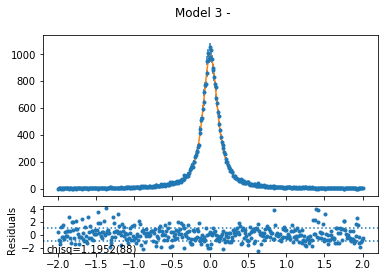

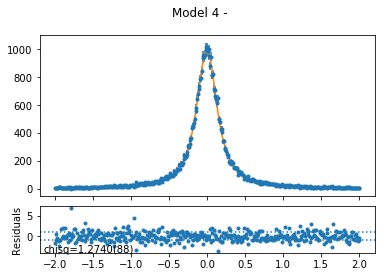

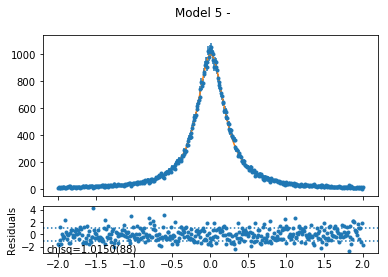

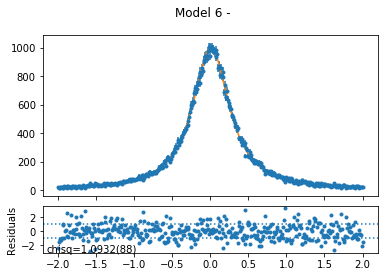

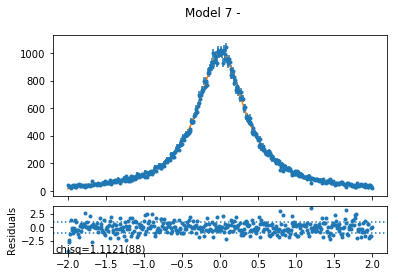

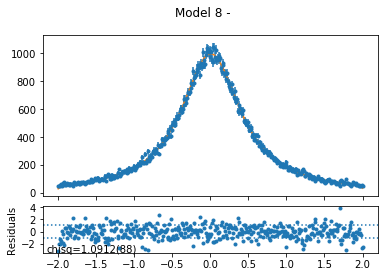

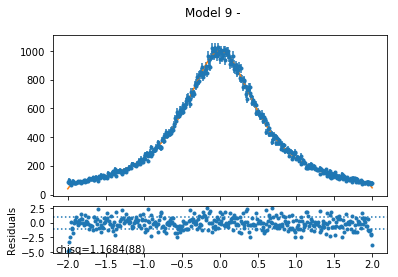

In [7]:
%run -m bumps.cli $model_file --fit=$minimiser --steps=$steps --store=$output_folder

(<a href='#Table of Contents'>Top</a>)<a id='results'></a><h2>Showing the results </h2>

In [12]:
# DISPLAY SOME RESULTS (Bumps output)
par_file = os.path.splitext(model_file)[0] + '.par'
err_file = os.path.splitext(model_file)[0] + '.err'

with open(os.path.join('.', output_folder, par_file), 'r') as fid:
    for line in fid:
        parameter, value = line.split()
        print(parameter, value)
        
with open(os.path.join(os.getcwd(), output_folder, err_file), 'r') as ferr:
    for line in ferr:
        print(line.rsplit('\n')[0])

D 0.144130167748887
center -0.000481870948378714
scale 110.889522857673
center 0.000350750149601242
scale 155.006448836014
center -0.000952242331455887
scale 229.014773140829
center -0.000314852293270532
scale 332.602689694197
center 5.69274622904399e-05
scale 484.247964851908
center 0.000695329751317372
scale 676.61986481149
center -0.00216231620581988
scale 904.543212295882
center 3.72022411010878e-05
scale 1176.00131571099
center 0.000569165990627964
scale 1475.3888634457
center -0.00112608663851177
scale 1823.90897206604
-- Model 0 
.D = Parameter(0.14413, name='D', bounds=(0,1))
.center = Parameter(-0.000481871, name='center', bounds=(-0.1,0.1))
.q = Parameter(0.2, name='q')
.scale = Parameter(110.89, name='scale', bounds=(0,100000))

[chisq=0.4039(88), nllf=80.9734]
-- Model 1 
.D = Parameter(0.14413, name='D', bounds=(0,1))
.center = Parameter(0.00035075, name='center', bounds=(-0.1,0.1))
.q = Parameter(0.4, name='q')
.scale = Parameter(155.006, name='scale', bounds=(0,100000))


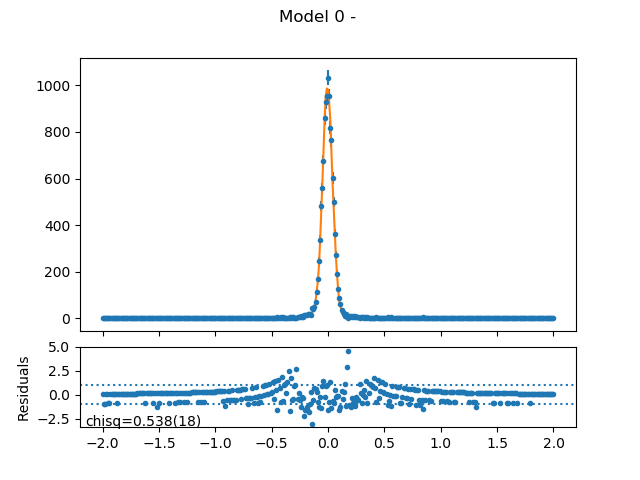

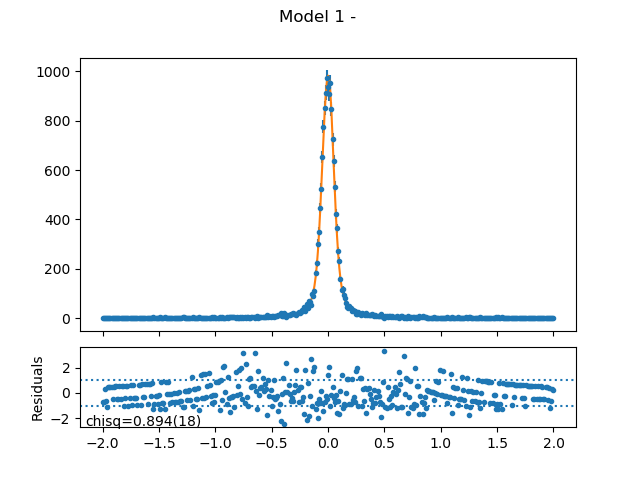

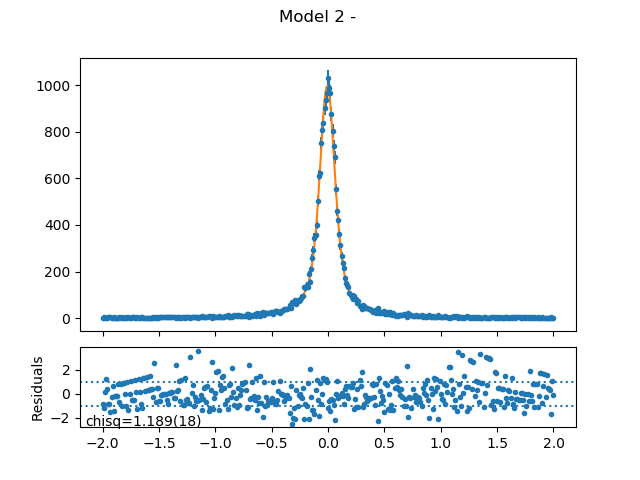

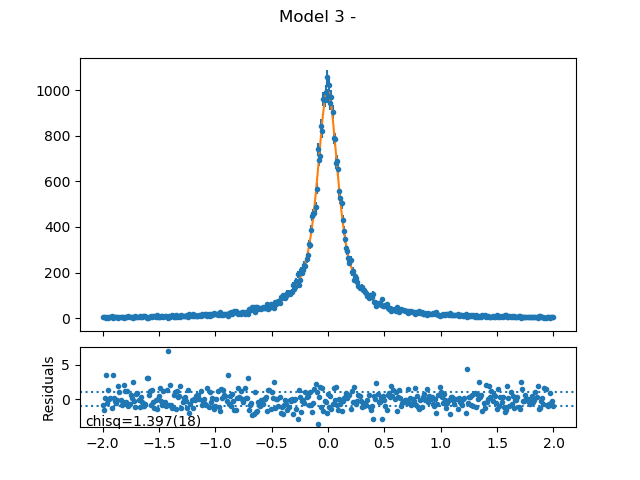

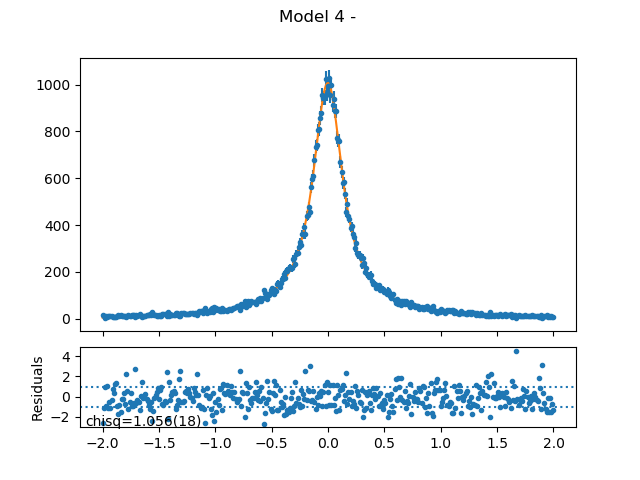

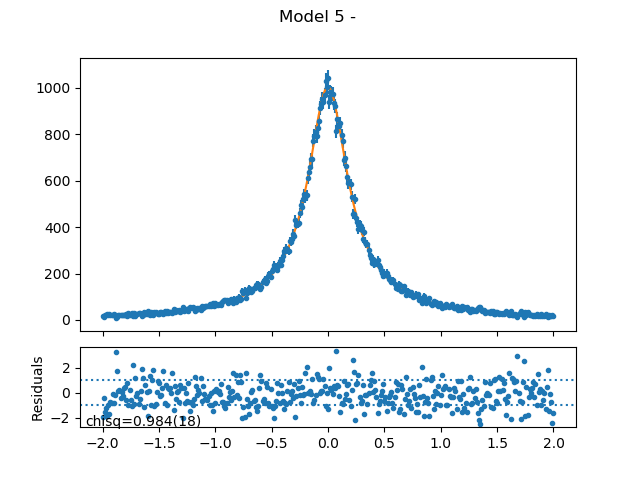

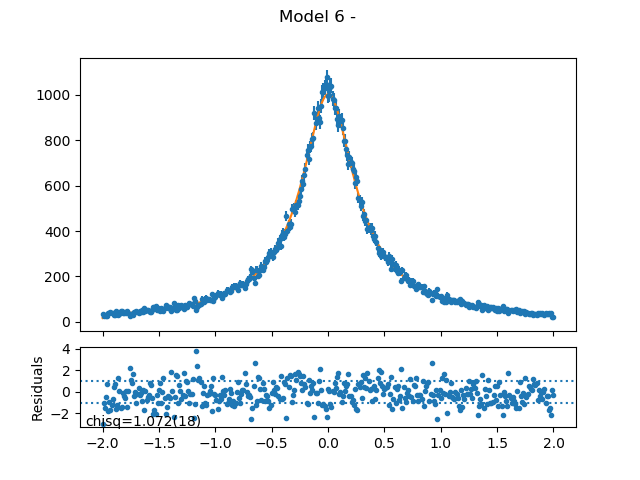

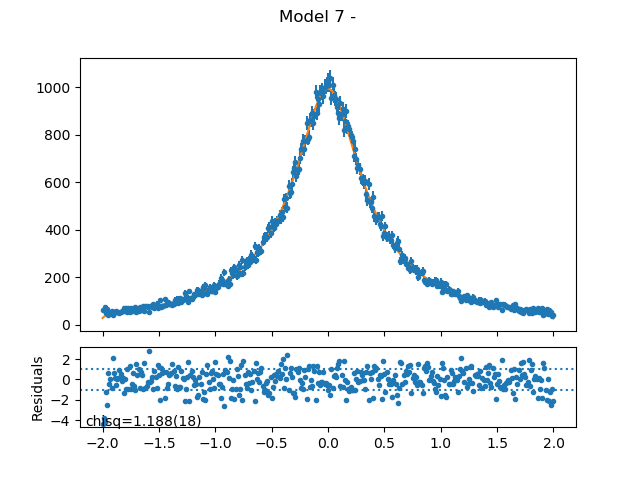

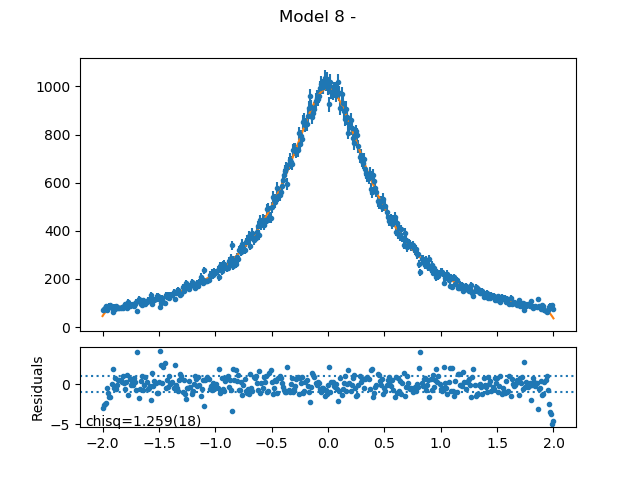

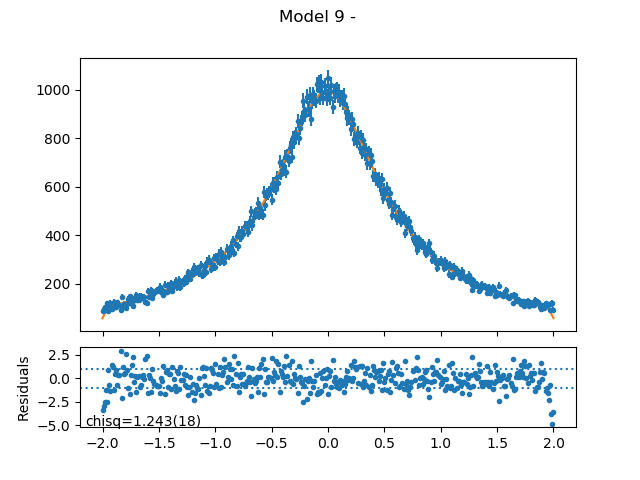

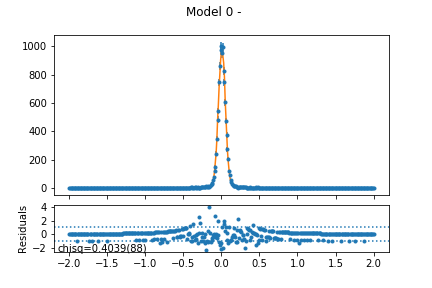

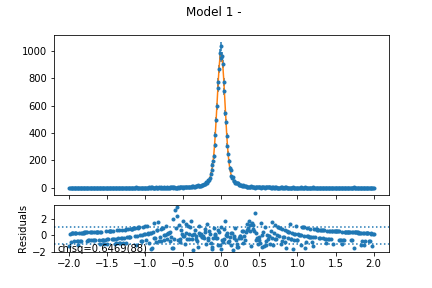

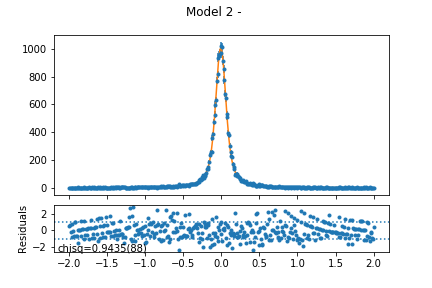

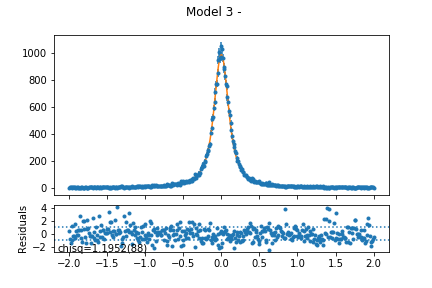

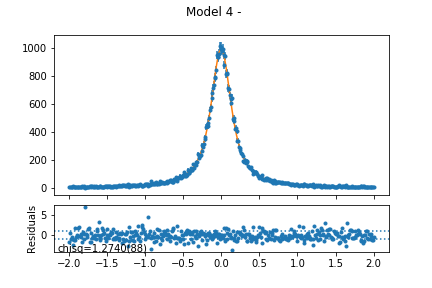

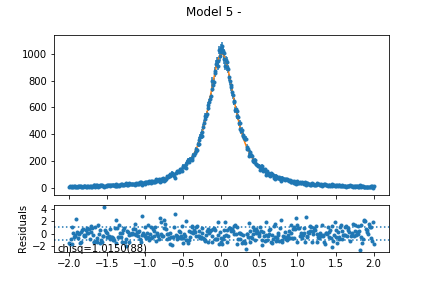

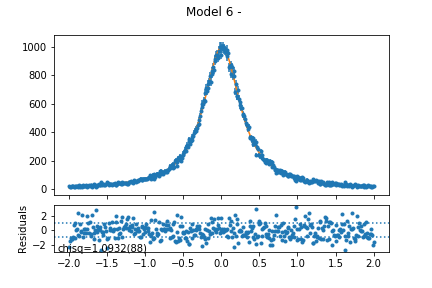

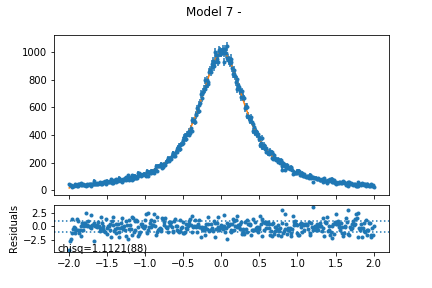

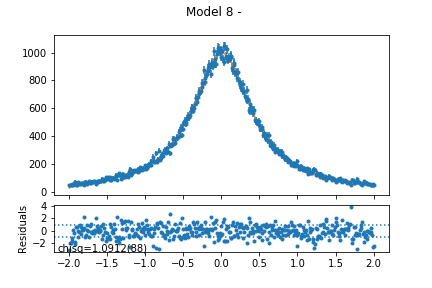

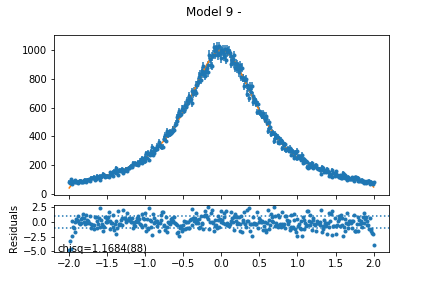

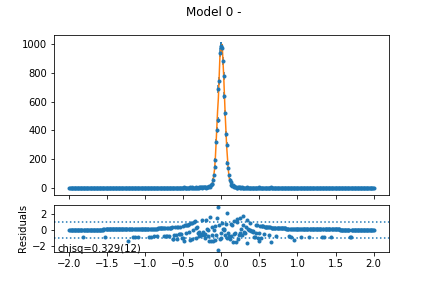

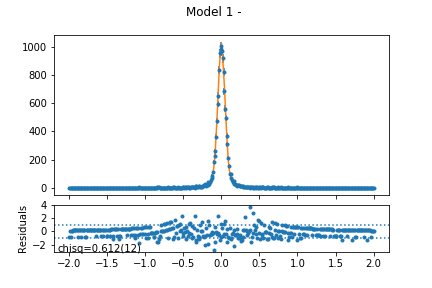

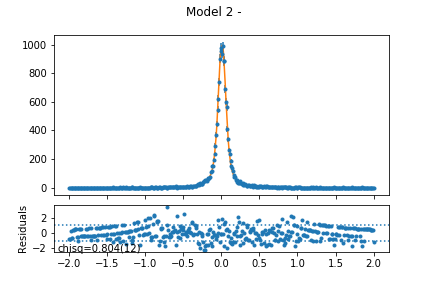

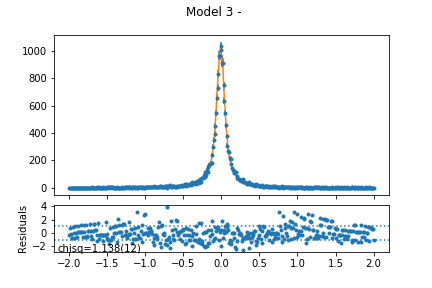

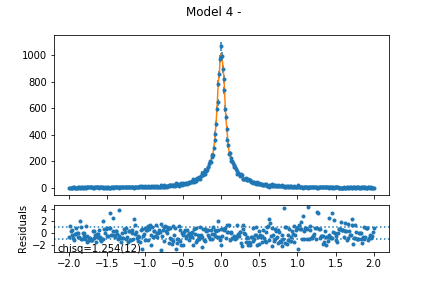

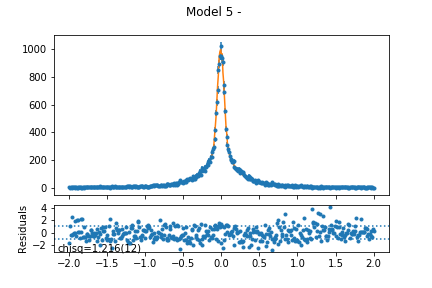

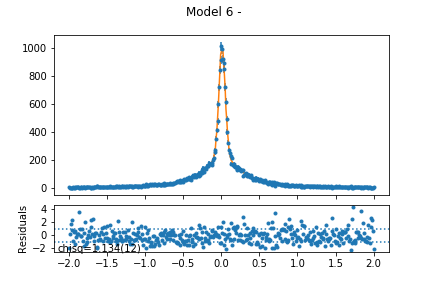

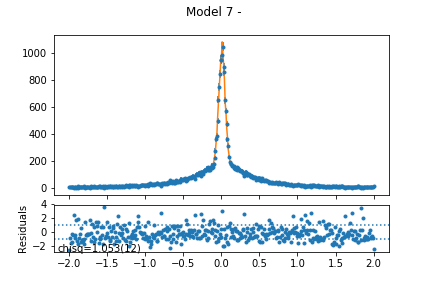

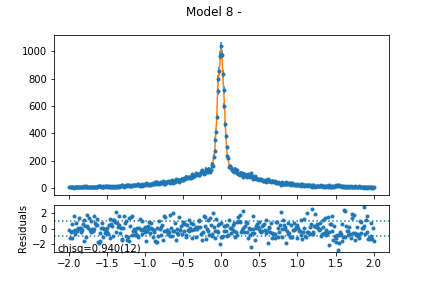

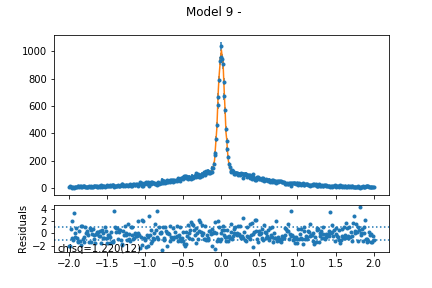

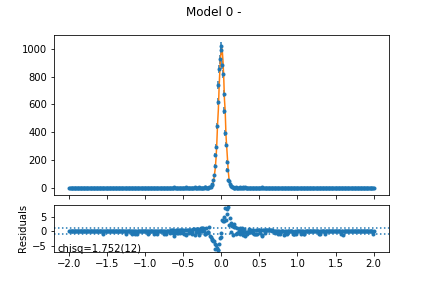

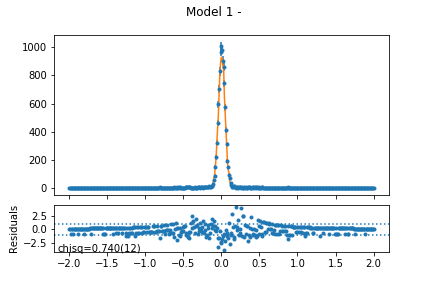

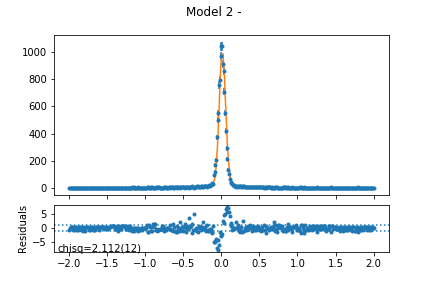

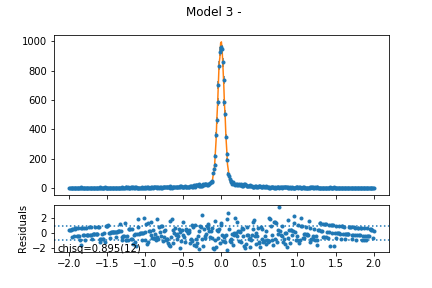

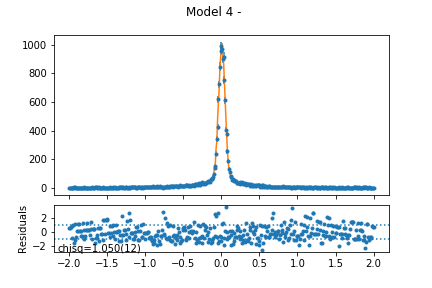

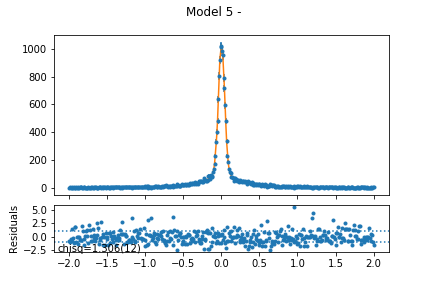

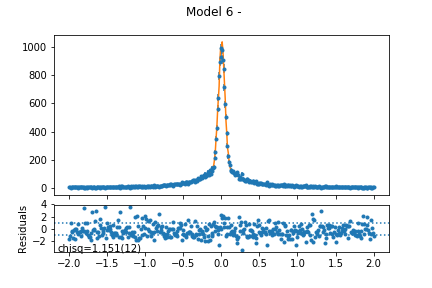

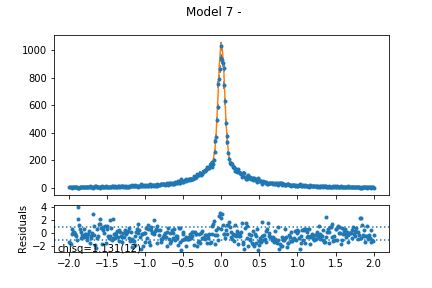

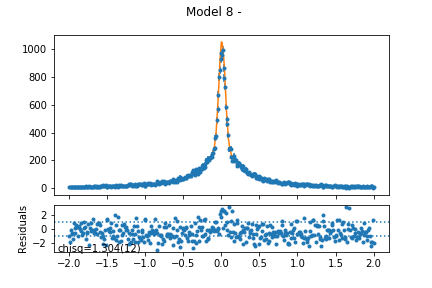

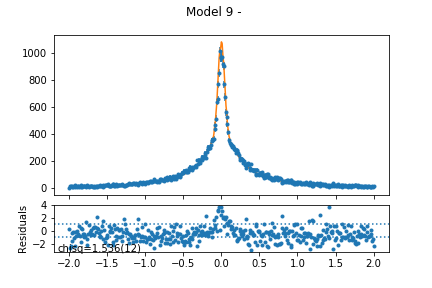

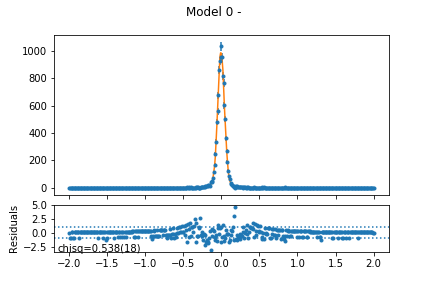

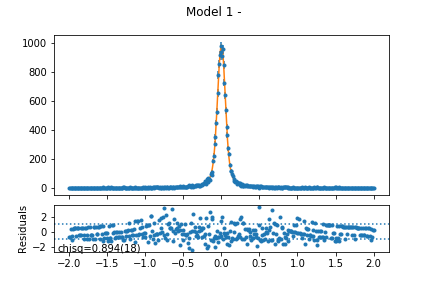

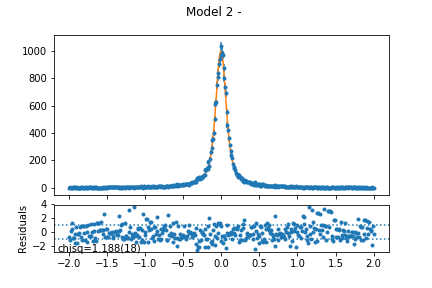

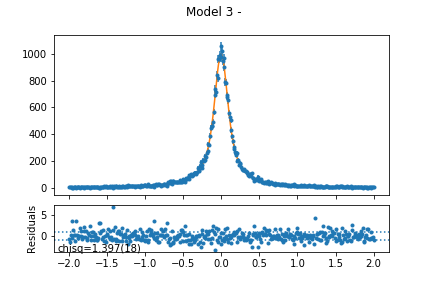

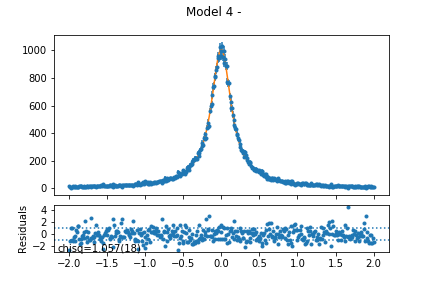

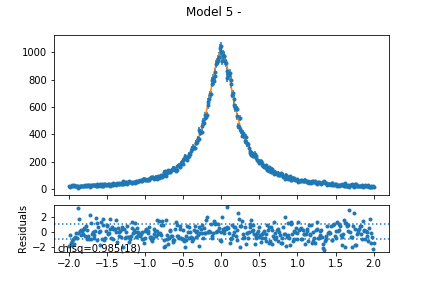

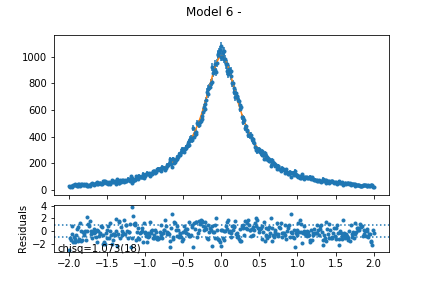

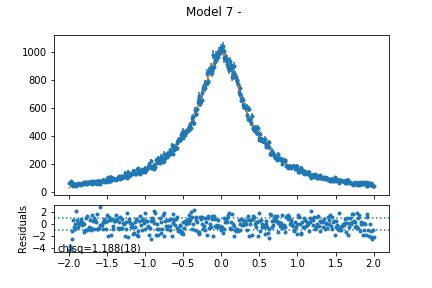

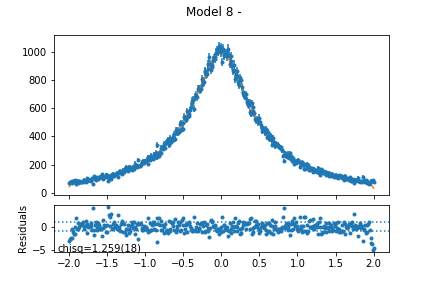

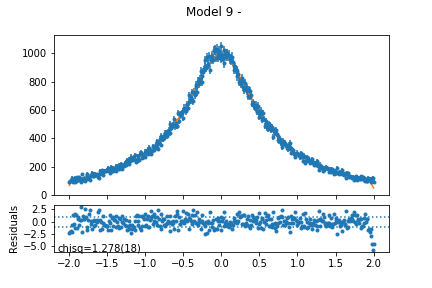

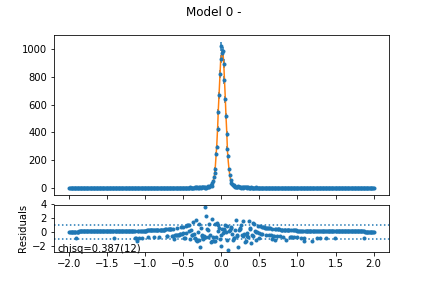

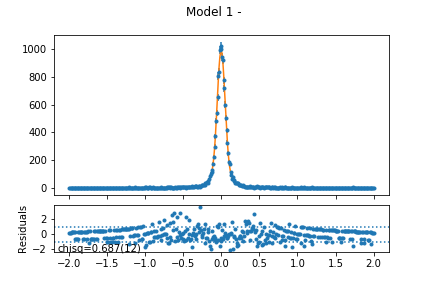

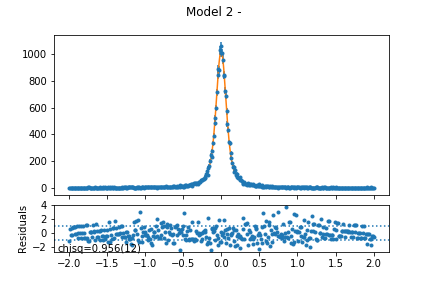

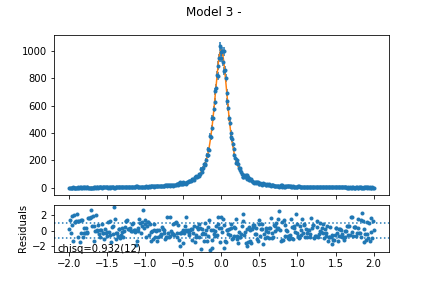

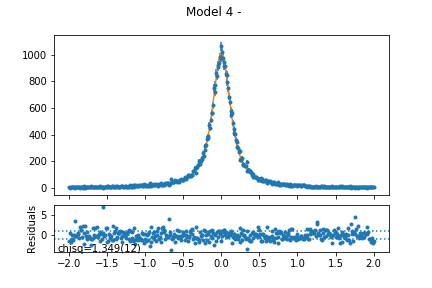

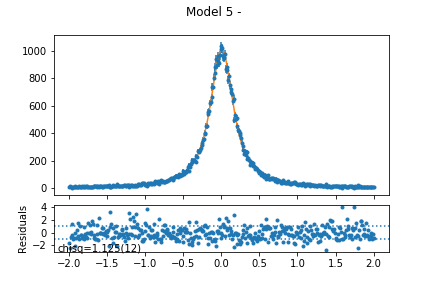

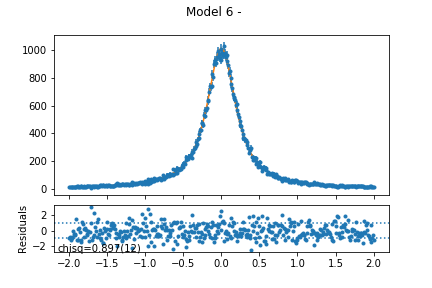

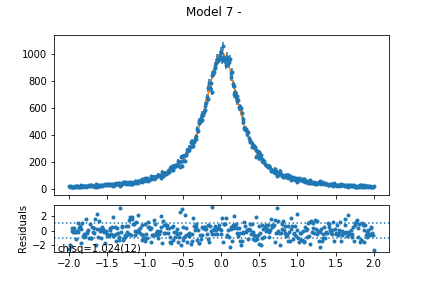

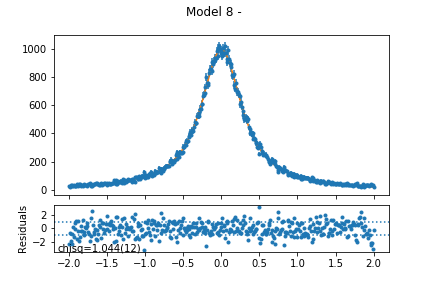

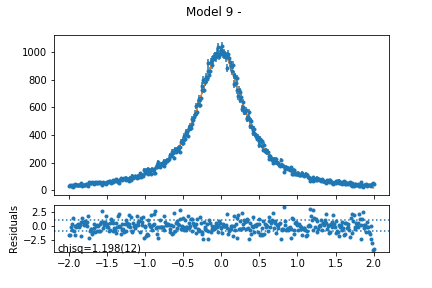

In [13]:
# Plot the fitting results

from IPython.display import display, Image
relative_output_path = os.path.join('.', output_folder)
names = [f for f in os.listdir(relative_output_path) if f.endswith('.png')]

for name in names:
    display(Image(os.path.join(relative_output_path, name)))